# Phase 2 
#### Group Members: Anusha Bishayee, Katheryn Ding, Phoebe Wang, Kaiwen Zhou

---

### Research Question:  

#### How do ESG performance and stock performance correlate across industries? What associations can we find between company industry, stock performance, and ESG rating?



---

### Data Description

This dataset contains ESG (Environmental, Social, and Governance) scores for 722 publicly traded companies, and represents a variety of different industries. Each row represents an individual company. The 21 columns include a CIK identifier, last processing date of the ESG data, company information (currency, logo/website URLs), environmental scores and ratings, social scores and ratings, governance scores and ratings, and overall ESG scores and ratings. We can combine this dataset with the Yahoo! Finance library in Python (yfinance, maintained by Ran Aroussi) to investigate if a company’s ESG score impacts its stock performance over time (time-series analysis): pypi.org/project/yfinance/. We do not intend to scrape data ourselves, but plan to utilize the yfinance library, which downloads market data from the Yahoo! Finance API, and appears to be free to use. We also will most likely filter this dataset from all 722 companies to just a few major companies of interest from select industries. Overall, our research question may be along the lines of “How do ESG ratings influence stock performance?” or “Do companies with high environmental ratings show less stock price volatility?”


We are using data from a Kaggle csv, and joining this to the yfinance library. First, we downloaded the ESG Kaggle csv, where each row corresponds to a different publicly traded company; this also contains ESG metrics for each company. We have filtered this dataset to only include companies that are traded in USD, and the columns all refer to a specific aspect of the company, such as industry, name, stock close/open/high/low prices, and ESG rating indexes. Then, we join this data to the yfinance library (Yahoo Finance) - from yfinance, we take the stock closing price of the company on 4/1/21 and 4/1/22. We also created a % Change variable, which measures the percentage change in the company stock closing price over the 2 years. All of this information is included in our large dataset - so the columns are company stock ticker, company name, currency, exchange, industry, logo, web url, environment grade, environment level, social grade, governance grade, governance level, environmental score, social score, governance score, total score, last processing date, total grade, total level, central index key, stock closing price in 4/1/21, stock closing price in 4/1/22, and the percent change between these. Our smaller dataset is meant to be a 'sample' of the original dataset with 722 rows, and involves a few companies that we hand-picked by notability. It contains all of the same columns, but only contains 23 companies. 

Our dataframes were created to show different stock prices of various companies over different date ranges, and the original ESG company data was created to compile ESG information for 700 mid / large-cap companies across various industries. Our combined dataframes was made to contrast both stock prices and ESG ratings of companies, and explore any associations. The original ESG company dataset was 'funded' by the efforts of Kaggle user Alistair King, and the yfinance dataset was created by Ran Aroussi as a way around the recent-ish Yahoo Finance API deprecation. For the ESG rating dataset, only mid/large-cap companies are included, so this influences the specific companies that are present in the dataset (the data that was observed and recorded) -- smaller companies will not be 'observed' here. 

The preprocessing was described above; we filtered our 722 row dataset for NaNs for our large dataset, and then for our sample dataset, we filtered all 722 companies down to 23 of interest, and joined all data to the yfinance library. Specifically, for each company, we acquired the stock closing price for 4/1/21 and 4/1/24, then created a stock change percentage variable between these two dates. 

Individuals are not involved in the data directly, as each observation corresponds to an entire company.

Our raw source data can be found in the yfinance library and https://www.kaggle.com/datasets/alistairking/public-company-esg-ratings-dataset/data, and the specific csv is here: https://github.com/phoebewang28/info-2950-project/blob/main/esg_data.csv. 




---

### Data Limitations
    
1. For our smaller dataset, the current sample of 23 companies was chosen manually by us as we wanted to get a range of industries that are well-known. This is limited to the companies that only use USD, and again, this data only records large/mid-cap companies, so this selection may not be fully representative of all US companies with ESG ratings. Depending on the results of of our analyses, we may consider random sampling or expanding the sample size to improve representativeness of our sample dataset.

2. We are currently comparing the rate of change of the sample stocks to the S&P 500, but other measures of stock performance might provide more valuable insights. For now, we are focusing on the rate of change between the closing prices of 4/1/21 and 4/1/22. 

3. Some stock data from yfinance is missing date information, which causes missing values when extracting prices. One company in our sample had this issue, so we had to exclude it to ensure consistency.

4. Since we are exploring potential connections between ESG ratings and company stock performance, we may need to sample not only by industry but also by ESG rating levels to ensure a more balanced and comprehensive analysis of the different ESG performance tiers (for our sample dataset)

5. ESG is a constent value retrieved from different days for each company in the month of April, 2022, while stock prices for these companies changes over time. We're unable to perform time-series analysis on ESG rating and stock informations due to the fact. 

6. ESG is evaluated annually, which might not be accuratly tracking the actual environmental performance of the company. Thus, when considering short-term impact of the company's esg policies, it's likely for that policy change to affect stock but not reflected on company's ESG rating.

---

### Data Collection and Cleaning

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import yfinance as yf

import os
import sys
import contextlib

filtering for just USD (not CNY or other currencies)

In [17]:
esg = pd.read_csv("esg_data.csv")
print(esg.shape)
esg = esg[esg["currency"] == "USD"]
print(esg.shape)

print(esg.head())


(722, 21)
(704, 21)
  ticker                           name currency  \
0    dis                 Walt Disney Co      USD   
1     gm              General Motors Co      USD   
2    gww                WW Grainger Inc      USD   
3    mhk          Mohawk Industries Inc      USD   
4    lyv  Live Nation Entertainment Inc      USD   

                        exchange                            industry  \
0  NEW YORK STOCK EXCHANGE, INC.                               Media   
1  NEW YORK STOCK EXCHANGE, INC.                         Automobiles   
2  NEW YORK STOCK EXCHANGE, INC.  Trading Companies and Distributors   
3  NEW YORK STOCK EXCHANGE, INC.                   Consumer products   
4  NEW YORK STOCK EXCHANGE, INC.                               Media   

                                                logo  \
0  https://static.finnhub.io/logo/ef50b4a2b263c84...   
1  https://static.finnhub.io/logo/9253db78-80c9-1...   
2  https://static.finnhub.io/logo/f153dcda-80eb-1...   
3  https:/

In [7]:
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

tickers = esg['ticker'].tolist()

stock_data = []

for ticker in tickers:
    try:
        # Suppress progress output with progress=False
        with suppress_output():  # Suppress all output during download
            stock = yf.download(ticker, start="2021-04-01", end="2022-04-01", progress=False)
        
        if not stock.empty:
            # Calculate percentage change using iloc to access positions
            percentage_change = ((stock['Close'].iloc[-1] - stock['Close'].iloc[0]) / stock['Close'].iloc[0]) * 100
            
            # Calculate volatility (std dev of daily returns)
            daily_returns = stock['Close'].pct_change()
            volatility = daily_returns.std()
            
            # Calculate 50-day moving average
            stock['50_day_SMA'] = stock['Close'].rolling(window=50).mean()
            sma_50_day = stock['50_day_SMA'].iloc[-1]
            
            # Calculate cumulative return using iloc
            cumulative_return = (stock['Close'].iloc[-1] / stock['Close'].iloc[0]) - 1
            
            # Append the data
            stock_data.append({
                'ticker': ticker, 
                'percentage_change': percentage_change,
                'volatility': volatility,
                '50_day_SMA': sma_50_day,
                'cumulative_return': cumulative_return
            })
    
    except (yf.YFTzMissingError, yf.YFPricesMissingError):
        pass 

# Convert stock data to DataFrame
stock_df = pd.DataFrame(stock_data)

# Merge stock data with ESG data
merged_df = esg.merge(stock_df, on='ticker', how='left')

print(merged_df.head())

  ticker                           name currency  \
0    dis                 Walt Disney Co      USD   
1     gm              General Motors Co      USD   
2    gww                WW Grainger Inc      USD   
3    mhk          Mohawk Industries Inc      USD   
4    lyv  Live Nation Entertainment Inc      USD   

                        exchange                            industry  \
0  NEW YORK STOCK EXCHANGE, INC.                               Media   
1  NEW YORK STOCK EXCHANGE, INC.                         Automobiles   
2  NEW YORK STOCK EXCHANGE, INC.  Trading Companies and Distributors   
3  NEW YORK STOCK EXCHANGE, INC.                   Consumer products   
4  NEW YORK STOCK EXCHANGE, INC.                               Media   

                                                logo  \
0  https://static.finnhub.io/logo/ef50b4a2b263c84...   
1  https://static.finnhub.io/logo/9253db78-80c9-1...   
2  https://static.finnhub.io/logo/f153dcda-80eb-1...   
3  https://static.finnhub.io/l

In [16]:
print(merged_df.shape)

(620, 25)
(620, 25)
<bound method NDFrame.head of     ticker                           name currency  \
0      dis                 Walt Disney Co      USD   
1       gm              General Motors Co      USD   
2      gww                WW Grainger Inc      USD   
3      mhk          Mohawk Industries Inc      USD   
4      lyv  Live Nation Entertainment Inc      USD   
..     ...                            ...      ...   
698    hgv     Hilton Grand Vacations Inc      USD   
699     hi                Hillenbrand Inc      USD   
701   hubs                    HubSpot Inc      USD   
702   hesm              Hess Midstream LP      USD   
703    hei                     HEICO Corp      USD   

                          exchange                            industry  \
0    NEW YORK STOCK EXCHANGE, INC.                               Media   
1    NEW YORK STOCK EXCHANGE, INC.                         Automobiles   
2    NEW YORK STOCK EXCHANGE, INC.  Trading Companies and Distributors   
3    

In [ ]:
#Extract S&P 500 rate
sp500_data = yf.download('^GSPC', start='2021-04-01',end='2022-04-01')
sp500_df = pd.DataFrame({
    'Date': sp500_data.index,
    'Start Price': sp500_data['Open'],
    'End Price': sp500_data['Close'],
    'Rate of Change (%)': ((sp500_data['Close'] - sp500_data['Open']) / sp500_data['Open']) * 100
})

sp500_df.set_index('Date', inplace=True)
print(sp500_df)

[*********************100%***********************]  1 of 1 completed

            Start Price    End Price  Rate of Change (%)
Date                                                    
2021-04-01  3992.780029  4019.870117            0.678477
2021-04-05  4034.439941  4077.909912            1.077472
2021-04-06  4075.570068  4073.939941           -0.039998
2021-04-07  4074.290039  4079.949951            0.138918
2021-04-08  4089.949951  4097.169922            0.176530
...                 ...          ...                 ...
2022-03-25  4522.910156  4543.060059            0.445507
2022-03-28  4541.089844  4575.520020            0.758192
2022-03-29  4602.859863  4631.600098            0.624400
2022-03-30  4624.200195  4602.450195           -0.470352
2022-03-31  4599.020020  4530.410156           -1.491837

[253 rows x 3 columns]


mess

In [ ]:
#use yfinance to pull stock information of selected stocks.
esg.loc[:, 'ticker'] = esg['ticker'].astype(str)
esg.loc[:, 'name'] = esg['name'].astype(str)
tickers = esg['ticker'].tolist()

#Add Start Price, End Price, and Rate of Change (%) of each company to the dataset esg
esg.loc[:, 'Start Price'] = None
esg.loc[:, 'End Price'] = None
esg.loc[:, 'Rate of Change (%)'] = None

# Loop through each row of the DataFrame to get stock information for each company
for index, row in esg.iterrows():
    ticker = row['ticker']
    
    # Download stock data for 2023
    data = yf.download(ticker, start='2021-04-01',end='2022-04-01')
    
    # Ensure data exists for the given period
    if not data.empty:
        start_price = data['Adj Close'].iloc[0]
        end_price = data['Adj Close'].iloc[-1]
        rate_of_change = ((end_price - start_price) / start_price) * 100
        
        # Add the stock data to the relevant columns in the DataFrame using .loc[]
        esg.loc[index, 'Start Price'] = start_price
        esg.loc[index, 'End Price'] = end_price
        esg.loc[index, 'Rate of Change (%)'] = rate_of_change

print(esg)

In [ ]:
#cleaning to only have certain companies that represent a variety of industries

companies = ["Walt Disney Co", "American Airlines Group Inc", "Apple Inc", "eBay Inc", "Goldman Sachs Group Inc", 
             "Meta Platforms Inc", "Starbucks Corp", "PayPal Holdings Inc", "United Airlines Holdings Inc", 
             "Bath & Body Works Inc", "Abbvie Inc", "Alexandria Real Estate Equities Inc", 
             "Becton Dickinson and Co", "Brown & Brown Inc", "Duke Energy Corp", "T-Mobile US Inc",
             "Marathon Oil Corp", "Chipotle Mexican Grill Inc", "Target Corp", 
             "General Motors Co", "Salesforce Inc", "Tesla Inc", "Bank of America Corp"]

relevant_esg = esg[esg["name"].isin(companies)]
print(relevant_esg)

In [ ]:
#use yfinance to pull stock information of selected stocks.
relevant_esg.loc[:, 'ticker'] = relevant_esg['ticker'].astype(str)
relevant_esg.loc[:, 'name'] = relevant_esg['name'].astype(str)
tickers = relevant_esg['ticker'].tolist()
#Add Start Price, End Price, and Rate of Change (%) of each company to the dataset relevent.esg
relevant_esg.loc[:, 'Start Price'] = None
relevant_esg.loc[:, 'End Price'] = None
relevant_esg.loc[:, 'Rate of Change (%)'] = None

# Loop through each row of the DataFrame to get stock information for each company
for index, row in relevant_esg.iterrows():
    ticker = row['ticker']
    
    # Download stock data for 2023
    data = yf.download(ticker, start='2021-04-01',end='2022-04-01')
    
    # Ensure data exists for the given period
    if not data.empty:
        start_price = data['Adj Close'].iloc[0]
        end_price = data['Adj Close'].iloc[-1]
        rate_of_change = ((end_price - start_price) / start_price) * 100
        
        # Add the stock data to the relevant columns in the DataFrame using .loc[]
        relevant_esg.loc[index, 'Start Price'] = start_price
        relevant_esg.loc[index, 'End Price'] = end_price
        relevant_esg.loc[index, 'Rate of Change (%)'] = rate_of_change

print(relevant_esg)


In [ ]:
#Add Start Price, End Price, and Rate of Change (%) of each company to the dataset esg
esg.loc[:, 'ticker'] = esg['ticker'].astype(str)
esg.loc[:, 'name'] = esg['name'].astype(str)
tickers = esg['ticker'].tolist()

# Add columns for Start Price, End Price, and Rate of Change (%)
esg['Start Price'] = None
esg['End Price'] = None
esg['Rate of Change (%)'] = None

# Loop through each row of the DataFrame to get stock information for each company
for index, row in esg.iterrows():
    ticker = row['ticker']
    
    # Skip rows where the ticker is not valid
    if ticker == 'nan' or ticker.strip() == "":
        continue
    
    # Download stock data for the given ticker
    data = yf.download(ticker, start='2021-04-01', end='2022-04-01')
    
    # Ensure data exists for the given period
    if not data.empty:
        start_price = data['Adj Close'].iloc[0]
        end_price = data['Adj Close'].iloc[-1]
        rate_of_change = ((end_price - start_price) / start_price) * 100
        
        # Add the stock data to the relevant columns in the DataFrame
        esg.loc[index, 'Start Price'] = start_price
        esg.loc[index, 'End Price'] = end_price
        esg.loc[index, 'Rate of Change (%)'] = rate_of_change

#Remove companies with missing value on stock information:
esg.dropna(subset=['Start Price', 'End Price', 'Rate of Change (%)'], inplace=True)

#show the first 15 rows of cleaned esg
print(esg.iloc[0:15,:])

---

### Exploratory Data Analysis

#### part one - exploring different average environmental, social, governance, and total ESG scores by industry

In [18]:
average_total_score_by_industry = merged_df.groupby('industry')['total_score'].mean().reset_index()
average_total_score_by_industry.columns = ['Industry', 'Average Total ESG Score']
print(average_total_score_by_industry.head(5))

avg_totals = average_total_score_by_industry.sort_values(by = 'Average Total ESG Score', ascending = False)
print("best average ESG scores")
print(avg_totals.head(5))

average_total_score_by_industry = average_total_score_by_industry.sort_values(by = 'Average Total ESG Score', ascending = True)
print("worst average ESG scores")
print(average_total_score_by_industry.head(5))

                Industry  Average Total ESG Score
0    Aerospace & Defense               633.000000
1  Aerospace and Defense              1089.700000
2               Airlines               838.714286
3        Auto Components               950.000000
4            Automobiles               938.000000
best average ESG scores
                    Industry  Average Total ESG Score
46                 Utilities              1190.633333
44                   Tobacco              1165.000000
24  Industrial Conglomerates              1157.000000
17                    Energy              1154.764706
34                 Packaging              1146.666667
worst average ESG scores
                         Industry  Average Total ESG Score
32                Metals & Mining                    615.0
0             Aerospace & Defense                    633.0
23  Hotels, Restaurants & Leisure                    746.0
26               Leisure Products                    780.0
18                        Energy

Text(0, 0.5, 'Industry')

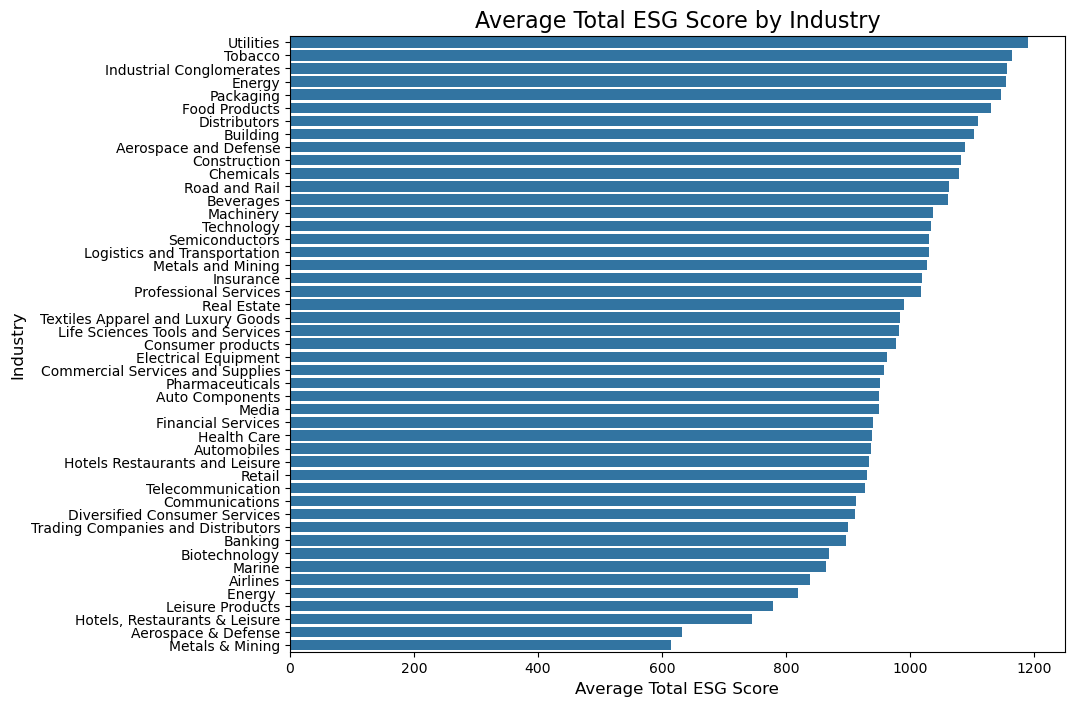

In [19]:
# Bar chart of Toatl ESG score by Industry
average_total_score_by_industry = average_total_score_by_industry.sort_values('Average Total ESG Score', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Average Total ESG Score', y='Industry', data=average_total_score_by_industry)

# Add labels and title
plt.title('Average Total ESG Score by Industry', fontsize=16)
plt.xlabel('Average Total ESG Score', fontsize=12)
plt.ylabel('Industry', fontsize=12)

interestingly (and somewhat predictably) - the industries with the lowest ESG scores are Metals & Mining, Aerospace & Defense, Diversified Consumer Services, Hotels, Restaurants & Leisure, Leisure Products, Auto Components, Airlines, and Automobiles. the industries with the highest ESG scores are Utilities, Tobacco, Industrial Conglomerates, Packaging, and Energy. 

future steps: sort different industries by just Environmental score, just Social score, and just Governance score to see if these differ significantly.

#### part two

In [ ]:
#Violin Plot: Governance Score by Environment Level
plt.figure(figsize=(12, 6))
sns.violinplot(data=esg, x='environment_level', y='governance_score', palette='muted')
plt.title('Governance Scores by Environment Level', fontsize=16)
plt.xlabel('Environment Level')
plt.ylabel('Governance Score')
plt.show()

In [ ]:
# Plot the distribution of total_score
plt.figure(figsize=(10, 6))
sns.histplot(esg['total_score'], kde=True, bins=20)
plt.title('Distribution of Total ESG Scores', fontsize=16)
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Boxplot of Total Scores by Total Grade
plt.figure(figsize=(12, 6))
sns.boxplot(data=esg, x='total_grade', y='total_score', palette='Set2')
plt.title('Total ESG Scores by Grade', fontsize=16)
plt.xlabel('Total Grade')
plt.ylabel('Total Score')
plt.show()

In [ ]:
#Scatter Plot: Rate of Change vs. Total ESG Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=esg, x='total_score', y='Rate of Change (%)', hue='total_grade', palette='coolwarm', s=100)
plt.title('Rate of Change (%) vs. Total ESG Score', fontsize=16)
plt.xlabel('Total ESG Score')
plt.ylabel('Rate of Change (%)')
plt.legend(title="ESG Grade", loc='upper right')
plt.show()

In [ ]:
#Boxplot: Rate of Change by Environment Grade
plt.figure(figsize=(12, 6))
sns.boxplot(data=esg, x='environment_grade', y='Rate of Change (%)', palette='Set2')
plt.title('Rate of Change (%) by Environmental Grade', fontsize=16)
plt.xlabel('Environment Grade')
plt.ylabel('Rate of Change (%)')
plt.show()


In [ ]:
#Violin Plot: Rate of Change by Social Grade
plt.figure(figsize=(12, 6))
sns.violinplot(data=esg, x='social_grade', y='Rate of Change (%)', palette='muted')
plt.title('Rate of Change (%) by Social Grade', fontsize=16)
plt.xlabel('Social Grade')
plt.ylabel('Rate of Change (%)')
plt.show()


In [ ]:
correlation_matrix=esg[['environment_score', 'social_score', 'governance_score', 'Rate of Change (%)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Between ESG Subscores and Stock Price Change')
plt.xticks(rotation=45)

plt.show()

correlation_environment = esg['environment_score'].corr(esg['Rate of Change (%)'])
correlation_social = esg['social_score'].corr(esg['Rate of Change (%)'])
correlation_governance = esg['governance_score'].corr(esg['Rate of Change (%)'])

print(f'Correlation between Environmental Score and Rate of Change (%): {correlation_environment:.3f}')
print(f'Correlation between Social Score and Rate of Change (%): {correlation_social:.3f}')
print(f'Correlation between Governance Score and Rate of Change (%): {correlation_governance:.3f}')


In [ ]:
# Plot histograms for each ESG subscore
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(esg['environment_score'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Environmental Score')
plt.ylabel('Frequency')
plt.title('Distribution of Environmental Scores')

plt.subplot(1, 3, 2)
plt.hist(esg['social_score'].dropna(), bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Social Score')
plt.ylabel('Frequency')
plt.title('Distribution of Social Scores')

plt.subplot(1, 3, 3)
plt.hist(esg['governance_score'].dropna(), bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Governance Score')
plt.ylabel('Frequency')
plt.title('Distribution of Governance Scores')

plt.tight_layout()
plt.show()


In [ ]:
env_scores = relevant_esg['environment_score'].values
soc_scores = relevant_esg['social_score'].values
gov_scores = relevant_esg['governance_score'].values
filtered_companies = relevant_esg['name'].values

x = np.arange(len(filtered_companies))

plt.figure(figsize=(12, 6))
plt.bar(x, env_scores, color='skyblue', label='Environmental Score')
plt.bar(x, soc_scores, bottom=env_scores, color='lightgreen', label='Social Score')
plt.bar(x, gov_scores, bottom=env_scores + soc_scores, color='lightcoral', label='Governance Score')

plt.xticks(x, filtered_companies, rotation=45, ha='right')
plt.xlabel('Company')
plt.ylabel('Score')
plt.title('Stacked Bar Chart of ESG Scores by Company')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
data = yf.download(list(relevant_esg['ticker']), start='2023-01-01', end='2024-01-01')['Adj Close']
        

plt.figure(figsize=(14, 8))
for ticker in data.columns:
    plt.plot(data.index, data[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.title('Stock Price Changes Over Time for Selected Companies')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
X = relevant_esg[['environment_score', 'social_score','governance_score']]   # Independent variables
y = relevant_esg['Rate of Change (%)']   # Dependent variable

model = LinearRegression().fit(X, y)
print(f"Environmental Score Coefficient: {model.coef_[0]}")
print(f"Social Score Coefficient: {model.coef_[1]}")
print(f"Governance Score Coefficient: {model.coef_[2]}")
print(f"Intercept: {model.intercept_}")


### Regression Coefficients Interpretation

For every 1-unit increase in the Environmental score (assuming all other factors remain constant), the stock return is expected to increase by 0.1079 units. The positive coefficient suggests that higher Environmental scores are associated with better stock performance (or higher returns).

For every 1-unit increase in the Social score (with other variables constant), the stock return is expected to decrease by 0.0237 units. The negative coefficient indicates that better Social scores might be associated with lower stock performance, but generally, since the coefficient is so close to 0, Social scores seem to have little impact on stock performance.

For every 1-unit increase in the Governance score (with other variables constant), stock return is expected to decrease by 0.0750 units. This negative coefficient suggests that improvements in governance (e.g., stricter regulation or more ethical practices) are associated with slightly lower stock returns. This could imply that governance improvements come at a financial cost.


In [ ]:
esg_corr = relevant_esg.loc[:, ['environment_score', 'social_score',
                                'governance_score']] 
print(esg_corr.corr(numeric_only=True))

In [ ]:
print(esg_corr.cov(numeric_only=True))

### Correlation and Covariance 

Let's observe the correlation/covariance between the different ESG scores themselves! All the correlations are positive, meaning that there is positive correlation between the scores (when one increases, the other does too). Governance and Environment have a particularly strong correlation, suggesting that companies who invest in environmental factors likely also care about governance (or perhaps some government regulations align with environmental issues). On the other hand, social factors seem to have just a moderately positive relationship with both the other variables.

While the covariance values agree with these claims, it's interesting to note how large the variance is for Environmental Scores (20758.63). This suggests that there is a large spread in environmental performance among the companies we chose, while governance scores are much more consistent.

---

### Questions for Reviewers

1. After combining our yfinance and ESG data, do we have large enough datasets to satisfy the complexity requirement for the research question?
   
2. Any advice recommanded to follow when we trying to take sample from the population? maybe by industry? how many industry to take sample from? maybe stratify to include all ESG grade? (as a reminder - we have one big dataset with 700+ companies and joined data that we did some EDA with, but we also want to include a smaller sample dataset so we can look at some individual companies as well).
   
3. How many visualization and statistics are recommanded for the final project? (ballpark range would be helpful) Do the visualizations we currently have seem like they're on the right path for the final phases?
   
4. Regarding the visualizations and chunks we have made for our EDA so far: should we explore these specific visualizations more in depth? OR should we expand our DA to other variables in the datasets that we maybe haven't used yet?